In [1]:
# Imports

import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna
import os
import logging
import json
import sys
import logging

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add parent directory to sys.path
sys.path.insert(0, parent_dir)

# Import
from sleepdetector_new import ImprovedSleepdetector



# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


def load_data(filepath, add_dim=False):
    try:
        # Load the data from the .mat file
        mat_file = sio.loadmat(filepath)
        
        # Stack the signals into x
        x = np.stack((mat_file['sig1'], mat_file['sig2'], mat_file['sig3'], mat_file['sig4']), axis=1)
        x = torch.from_numpy(x).float()  # Convert to PyTorch tensor
        
        # Load the labels
        y = torch.from_numpy(mat_file['labels'].flatten()).long()
        
        # Remove epochs where y is -1 (if any)
        valid_indices = y != -1
        x = x[valid_indices]
        y = y[valid_indices]
        
        # x is already in shape [number of epochs, 4, 3000], so no need to permute
        
        if add_dim:
            x = x.unsqueeze(1)  # Add an extra dimension if required
        
        return x, y

    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise


def extract_spectral_features(x):
    features = []
    for channel in x:
        f, psd = welch(channel.squeeze().numpy(), fs=100, nperseg=1000)
        delta = np.sum(psd[(f >= 0.5) & (f <= 4)])
        theta = np.sum(psd[(f > 4) & (f <= 8)])
        alpha = np.sum(psd[(f > 8) & (f <= 13)])
        beta = np.sum(psd[(f > 13) & (f <= 30)])
        features.extend([delta, theta, alpha, beta])
    return np.array(features)

def prepare_data(x, y, test_size=0.2, split=True):
    """
    Prepare data for training or testing.
    
    :param x: Input data tensor
    :param y: Labels tensor
    :param test_size: Proportion of the dataset to include in the test split
    :param split: If True, split the data into train and test sets. If False, process all data without splitting.
    :return: Processed data tensors
    """
    if split:
        X_train, X_test, y_train, y_test = train_test_split(x.numpy(), y.numpy(), test_size=test_size, stratify=y, random_state=42)
        
        X_train_spectral = np.array([extract_spectral_features(torch.from_numpy(x)) for x in X_train])
        X_test_spectral = np.array([extract_spectral_features(torch.from_numpy(x)) for x in X_test])
        
        X_train_combined = np.concatenate([X_train.reshape(X_train.shape[0], -1), X_train_spectral], axis=1)
        X_test_combined = np.concatenate([X_test.reshape(X_test.shape[0], -1), X_test_spectral], axis=1)
        
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)
        
        original_shape = list(X_train.shape)
        original_shape[0] = X_train_resampled.shape[0]
        spectral_shape = (X_train_resampled.shape[0], X_train_spectral.shape[1])
        
        X_train_final = X_train_resampled[:, :-X_train_spectral.shape[1]].reshape(original_shape)
        X_train_spectral_final = X_train_resampled[:, -X_train_spectral.shape[1]:].reshape(spectral_shape)
        
        return (torch.from_numpy(X_train_final).float(),
                torch.from_numpy(X_train_spectral_final).float(),
                torch.from_numpy(y_train_resampled).long(),
                torch.from_numpy(X_test).float(),
                torch.from_numpy(X_test_spectral).float(),
                torch.from_numpy(y_test).long())
    else:
        X_spectral = np.array([extract_spectral_features(x_i) for x_i in x])
        
        return (x.float(),
                torch.from_numpy(X_spectral).float(),
                y.long())

# Model definition
class EnsembleModel(nn.Module):
    def __init__(self, model_params, n_models=3):
        super().__init__()
        self.models = nn.ModuleList([ImprovedSleepdetector(**model_params) for _ in range(n_models)])
    
    def forward(self, x, spectral_features):
        outputs = [model(x.clone(), spectral_features.clone()) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

# Training and evaluation functions
def train_model(model, train_loader, val_data, optimizer, scheduler, criterion, device, epochs=100):
    best_accuracy = 0
    best_model_state = None
    
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        for batch_x, batch_x_spectral, batch_y in train_loader:
            batch_x, batch_x_spectral, batch_y = batch_x.to(device), batch_x_spectral.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x, batch_x_spectral)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        accuracy = evaluate_model(model, val_data, device)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict()
        
        scheduler.step(accuracy)
    
    return best_model_state, best_accuracy

# def evaluate_model(model, data, device):
#     model.eval()
#     X, X_spectral, y = data
#     with torch.no_grad():
#         outputs = model(X.to(device), X_spectral.to(device))
#         _, predicted = torch.max(outputs, 1)
#         accuracy = accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())
#     return accuracy

def evaluate_model(model, data, device):
    model.eval()
    try:
        X, X_spectral, y = data
        logging.info(f"Data shapes - X: {X.shape}, X_spectral: {X_spectral.shape}, y: {y.shape}")
        
        with torch.no_grad():
            outputs = model(X.to(device), X_spectral.to(device))
            logging.info(f"Model output shape: {outputs.shape}")
            
            _, predicted = torch.max(outputs, 1)
            logging.info(f"Predicted shape: {predicted.shape}")
            
            accuracy = accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())
            kappa = cohen_kappa_score(y.cpu().numpy(), predicted.cpu().numpy())
            
        return accuracy, kappa, predicted.cpu().numpy()
    except Exception as e:
        logging.error(f"Error in evaluate_model: {e}")
        raise

# Hyperparameter optimization
def objective(trial, X_train, X_train_spectral, y_train, X_test, X_test_spectral, y_test, device):
    model_params = {
        'n_filters': trial.suggest_categorical('n_filters', [[32, 64, 128], [64, 128, 256]]),
        'lstm_hidden': trial.suggest_int('lstm_hidden', 64, 512),
        'lstm_layers': trial.suggest_int('lstm_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5)
    }
    
    train_params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    }
    
    model = ImprovedSleepdetector(**model_params).to(device)
    optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
    train_loader = DataLoader(TensorDataset(X_train, X_train_spectral, y_train), batch_size=train_params['batch_size'], shuffle=True)
    
    _, accuracy = train_model(model, train_loader, (X_test, X_test_spectral, y_test), optimizer, ReduceLROnPlateau(optimizer), nn.CrossEntropyLoss(), device, epochs=10)
    
    return accuracy

# Cross-validation
def cross_validate(X, X_spectral, y, model_params, train_params, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        X_spectral_train_fold, X_spectral_val_fold = X_spectral[train_idx], X_spectral[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model = ImprovedSleepdetector(**model_params).to(device)
        optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
        train_loader = DataLoader(TensorDataset(X_train_fold, X_spectral_train_fold, y_train_fold), batch_size=train_params['batch_size'], shuffle=True)
        
        _, accuracy = train_model(model, train_loader, (X_val_fold, X_spectral_val_fold, y_val_fold), optimizer, ReduceLROnPlateau(optimizer), nn.CrossEntropyLoss(), device, epochs=50)
        scores.append(accuracy)
        
        logging.info(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    
    logging.info(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return scores

# Confusion matrix plotting
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Class names in the correct order (0 to 4)
    class_names = ['N3', 'N2', 'N1', 'REM', 'Awake']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, square=True, xticklabels=class_names, yticklabels=class_names)
    
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)
    
    plt.tight_layout()
    return fig

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Usage
x, y = load_data('preprocessed_data_combined.mat')
X, X_spectral, y = prepare_data(x, y, split=False)
print(f"X shape: {x.shape}, Y shape: {y.shape}")

X shape: torch.Size([1069, 4, 3000]), Y shape: torch.Size([1069])


In [3]:
x.shape, y.shape

(torch.Size([1069, 4, 3000]), torch.Size([1069]))

Total Length of time in hours: 8.908333333333333


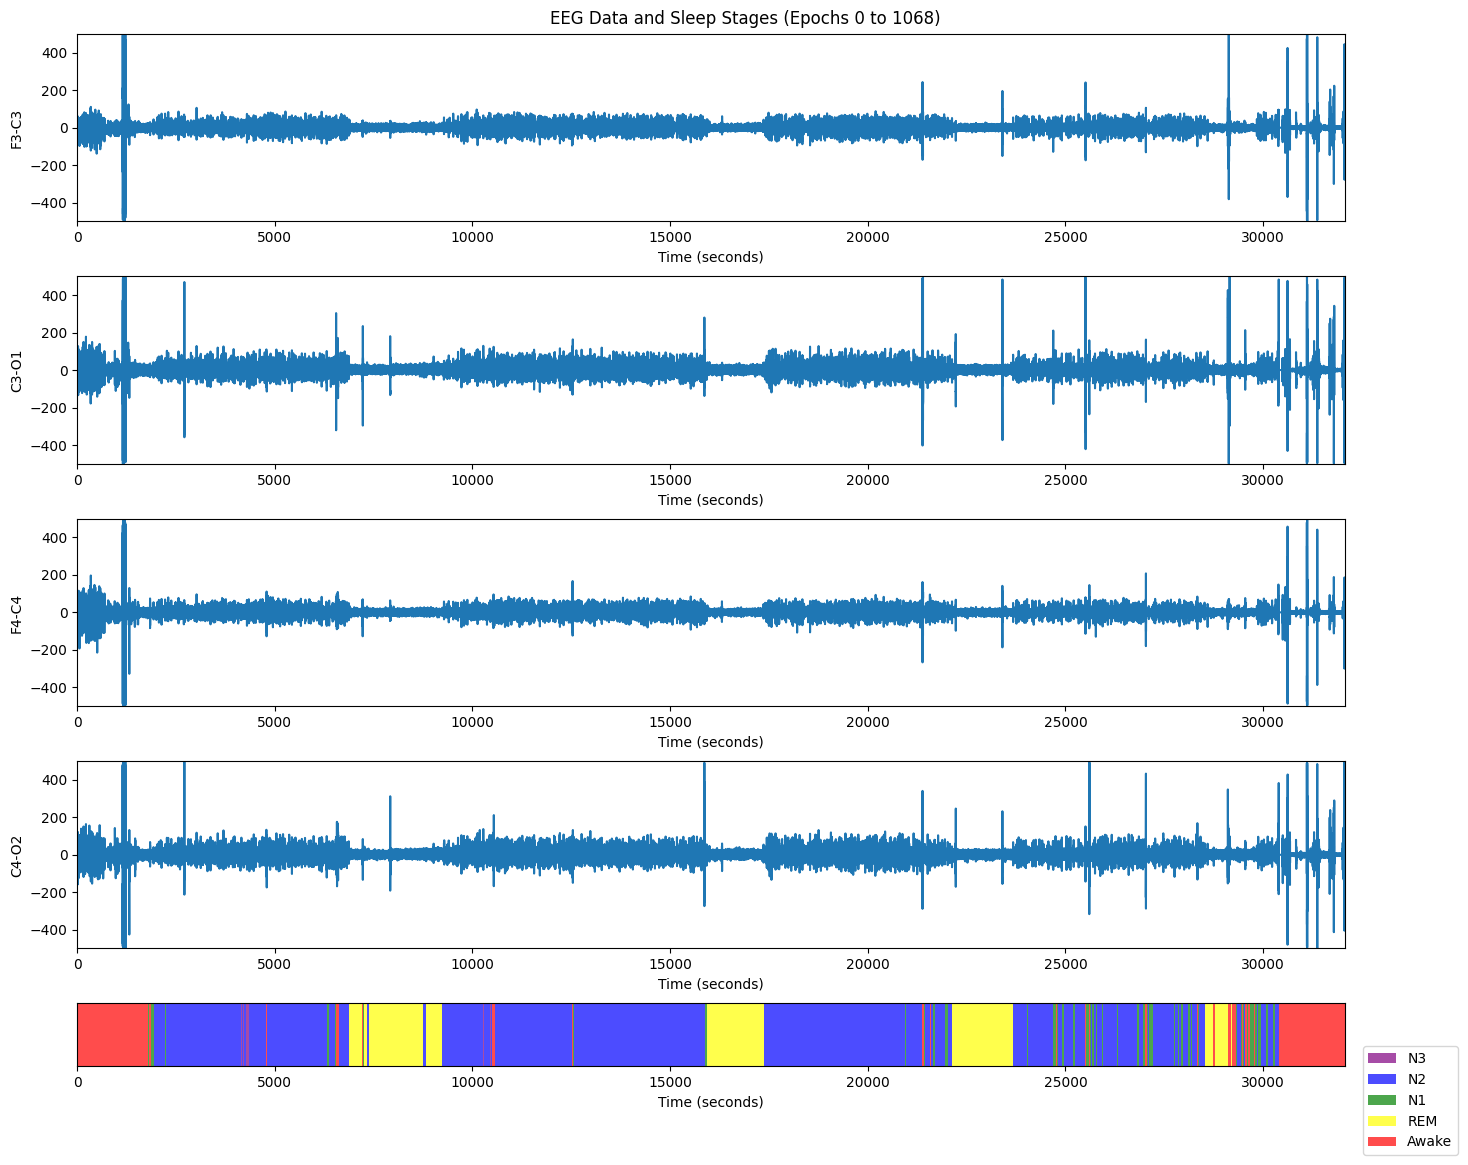

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.io
from matplotlib.colors import ListedColormap

def plot_eeg_and_sleep_stages(x, y, fs, ch_names, start_epoch=0, num_epochs=None):
    """
    Plot EEG data and corresponding sleep stages.
    
    :param x: EEG data tensor of shape (epochs, channels, time)
    :param y: Sleep stage labels tensor of shape (epochs,)
    :param fs: Sampling frequency (Hz)
    :param ch_names: List of EEG channel names
    :param start_epoch: Starting epoch to plot (default 0)
    :param num_epochs: Number of epochs to plot (default is all epochs)
    """
    if num_epochs is None:
        num_epochs = x.shape[0]
    
    start_epoch = max(0, min(start_epoch, x.shape[0] - num_epochs))
    
    plot_x = x[start_epoch:start_epoch+num_epochs].numpy()
    plot_y = y[start_epoch:start_epoch+num_epochs].numpy()
    
    num_samples_per_epoch = plot_x.shape[2]
    total_samples = num_epochs * num_samples_per_epoch
    time_vector = np.arange(total_samples) / fs
    
    # fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [3, 3, 3, 3, 1]})
    fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=False, gridspec_kw={'height_ratios': [3, 3, 3, 3, 1]})
    fig.suptitle(f'EEG Data and Sleep Stages (Epochs {start_epoch} to {start_epoch+num_epochs-1})')
    
    for i in range(4):
        flattened_data = plot_x[:, i, :].flatten()
        axs[i].plot(time_vector, flattened_data)
        axs[i].set_ylabel(ch_names[i])
        axs[i].set_xlim(0, total_samples / fs)
        axs[i].set_ylim(flattened_data.min(), flattened_data.max())
    
    stage_colors = ['purple', 'blue', 'green', 'yellow', 'red']  # Colors for N3, N2, N1, REM, Awake
    cmap = ListedColormap(stage_colors)
    
    epoch_duration = num_samples_per_epoch / fs
    for i, stage in enumerate(plot_y):
        start = i * epoch_duration
        end = (i + 1) * epoch_duration
        axs[4].axvspan(start, end, facecolor=stage_colors[int(stage)], alpha=0.7)
    
    axs[4].set_yticks([])
    # axs[4].set_xlabel('Time (seconds)')   
    axs[4].set_xlim(0, total_samples / fs)

    print("Total Length of time in hours:", total_samples / fs / 3600)

    for i in range(5):  # Now including the sleep stage plot
        axs[i].set_xlabel('Time (seconds)')

    # Create legend elements
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=stage_colors[i], alpha=0.7) 
                       for i in range(5)]
    
    # Add legend to the right side under the graph
    fig.legend(legend_elements, ['N3', 'N2', 'N1', 'REM', 'Awake'], 
               loc='lower right', bbox_to_anchor=(0.98, 0.02), ncol=1)
    
    plt.tight_layout()
    # Adjust the layout to make room for the legend
    plt.subplots_adjust(bottom=0.1, right=.9)
    return fig

# Usage remains the same
fs = scipy.io.loadmat('./preprocessed_data.mat')['Fs'].flatten()[0]
ch_names = scipy.io.loadmat('./preprocessed_data.mat')['ch_names'].flatten().tolist()

# Plot all epochs
plot_eeg_and_sleep_stages(x, y, fs, ch_names, start_epoch=0, num_epochs=None)
plt.show()

2024-09-24 10:46:22,978 - INFO - Loaded best model parameters: {'n_filters': [64, 128, 256], 'lstm_hidden': 270, 'lstm_layers': 1, 'dropout': 0.1724846458910379}
/var/folders/4f/sgn_zcm52nl7hs_clb0tdbph0000gn/T/ipykernel_13584/1997328008.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have f

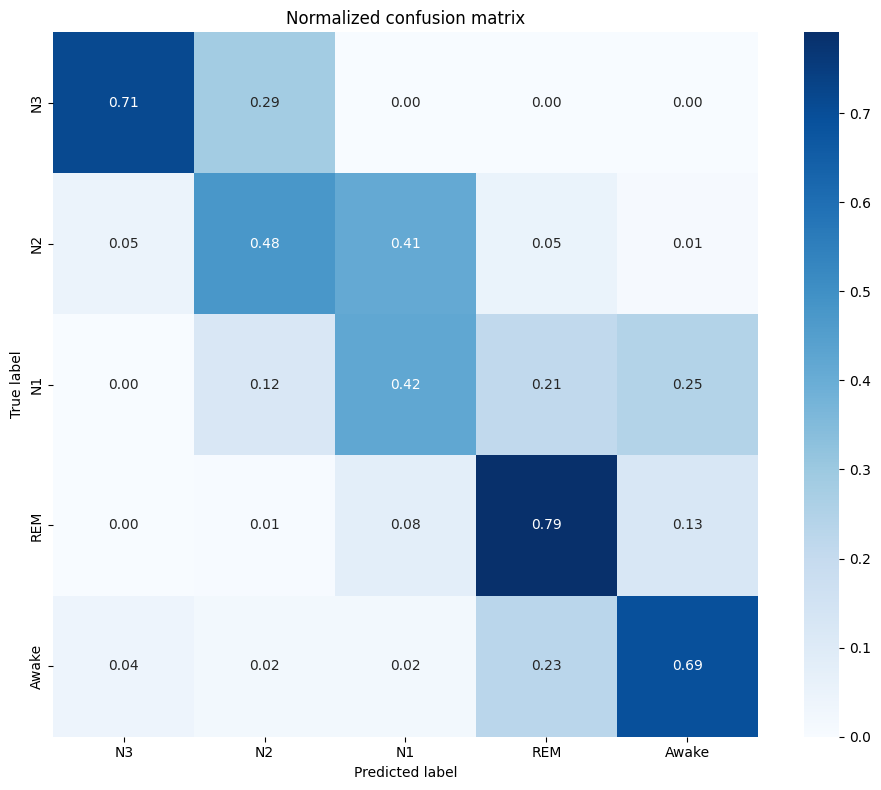

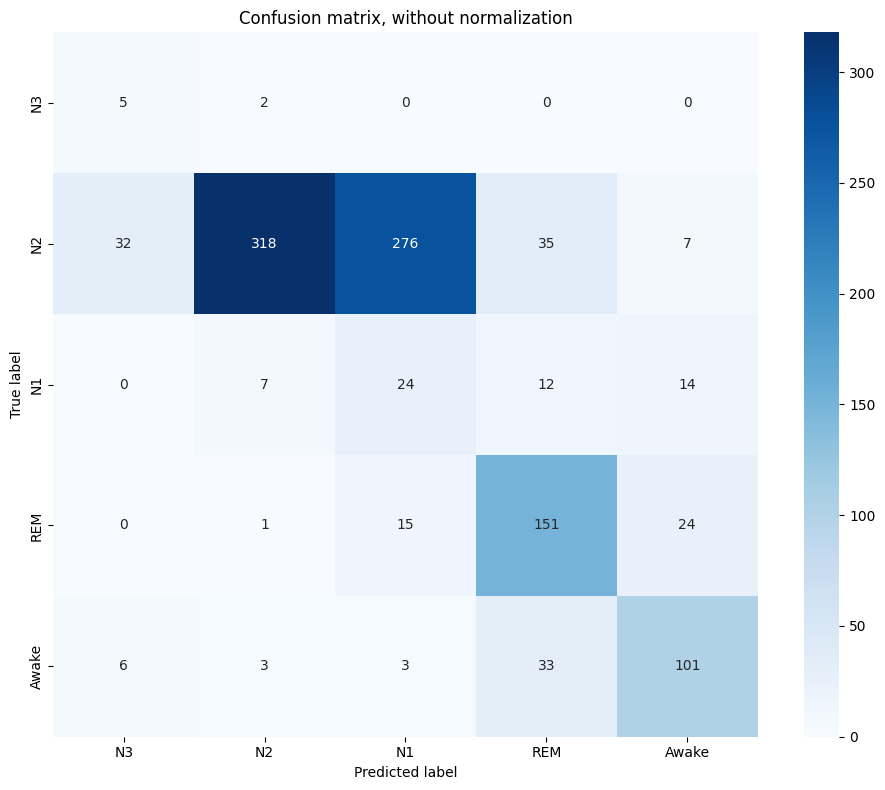

In [5]:
try:
    # Load the best parameters from JSON file
    with open('../models/best_params_ensemble.json', 'r') as f:
        params = json.load(f)
    
    best_model_params = params['best_model_params']
    logging.info(f"Loaded best model parameters: {best_model_params}")

    # Load the saved model
    model_state = torch.load("../models/best_ensemble_model.pth", map_location=device)
    
    # Recreate the model architecture using the loaded parameters
    model = EnsembleModel(best_model_params, n_models=3).to(device)
    
    # Load the state dict
    model.load_state_dict(model_state)
    logging.info("Model loaded successfully")

    # Evaluate the model
    logging.info("Starting model evaluation")
    accuracy, kappa, predictions = evaluate_model(model, (X, X_spectral, y), device)
    
    logging.info(f"Test Accuracy: {accuracy:.4f}")
    logging.info(f"Cohen's Kappa: {kappa:.4f}")

    # Plot and save confusion matrices
    fig_norm = plot_confusion_matrix(y.numpy(), predictions, normalize=True)
    fig_norm.savefig('../images/confusion_matrix_normalized.png')
    logging.info("Normalized confusion matrix saved to 'images' folder as 'confusion_matrix_normalized.png'") 
    

    fig_non_norm = plot_confusion_matrix(y.numpy(), predictions, normalize=False)
    fig_non_norm.savefig('../images/confusion_matrix_non_normalized.png')
    logging.info("Non-normalized confusion matrix saved to 'images' folder as 'confusion_matrix_non_normalized.png'")

except Exception as e:
    logging.error(f"An error occurred: {e}")
    logging.error(f"Error type: {type(e)}")
    logging.error(f"Error args: {e.args}")
    # Optionally, print the full traceback
    import traceback
    logging.error(f"Traceback: {traceback.format_exc()}")